In [73]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os, glob

In [74]:
def block_audio(x, block_size, hop_size, fs):
    # Compute the number of blocks
    num_blocks = int((len(x) - block_size) / hop_size) + 1

    # Initialize the blocks
    xb = np.zeros((num_blocks, block_size))

    # Initialize the timestamps
    timeInSec = np.zeros(num_blocks)

    # Compute the blocks and timestamps
    for i in range(num_blocks):
        start = i * hop_size
        end = start + block_size
        xb[i] = x[start:end]
        timeInSec[i] = start / fs

    return xb, timeInSec

In [75]:
def comp_acf(input_vector, is_normalized):

  # Compute the autocorrelation and take the second half
  result = np.correlate(input_vector, input_vector, mode='full')[len(input_vector)-1:]

  if is_normalized:
    result /= result[0]

  # Generate lags
  lags = np.arange(0, len(result), 1)

  return result
  # Brittney

In [76]:
def get_f0_from_acf(r, fs):
    """
    Estimate frequency using autocorrelation
    """
    sigcorr = comp_acf(r, True)

    # Range of indices
    lag_range = range(1, len(sigcorr))  # Exclude lag 0

    # Narrowed range
    min_lag = 12
    max_lag = 120
    restricted_range = range(min_lag, min(max_lag, len(sigcorr)))

    # Find the index of the maximum value within the restricted range
    peak = max(restricted_range, key=lambda x: sigcorr[x])

    # Fundamental frequency
    f0 = fs / peak

    return f0
    # Brittney

In [77]:
def track_pitch_acf(x, block_size, hop_size, fs=44100):
    xb, timeInSec = block_audio(x, block_size, hop_size, fs)

    num_blocks = len(xb)
    f0 = np.zeros((num_blocks, block_size))

    for i in range(num_blocks):
        f0[i] = get_f0_from_acf(xb[i], fs)

    return f0, timeInSec
    #Jerry

In [78]:
def convert_freq2midi(freq_in_hz):
  freq_in_hz= np.array(freq_in_hz)
  pitch_in_MIDI = 69+12*np.log2(freq_in_hz/440)
  return pitch_in_MIDI
  #Anish B1.

In [79]:
def eval_pitchtrack(estimate_in_hz, groundtruth_in_hz):
    error_in_cents = 0

    counter = 0
    for i in range(len(estimate_in_hz)):

        if estimate_in_hz[i] != 0 and groundtruth_in_hz[i] != 0:
            counter += 1
            error_in_cents += np.square(1200*np.log2(estimate_in_hz[i]/groundtruth_in_hz[i]))

    error_in_cents /= counter 
                                

    errcentRMS = np.sqrt(error_in_cents)

    return errcentRMS
    #Anish and Jerry B2.

In [80]:
def generate_sine(freq1, freq2, amp, dur, fs):
    duration1 = dur
    duration2 = dur

    # generate timeline
    t1 = np.linspace(0, duration1, int(fs * duration1), False)
    t2 = np.linspace(0, duration2, int(fs * duration2), False)

    # generate sine waves
    signal1 = 1 * np.sin(2 * np.pi * freq1 * t1)
    signal2 = 1 * np.sin(2 * np.pi * freq2 * t2)

    # concatenate
    signal_ = np.concatenate([signal1, signal2])
    t_ = np.concatenate([t1, t2])

    return signal_, t_
    # Brittney

In [81]:
def plot_test(xb, block_size, hop_size, fs):
  # Store frequency and error values
  frequency_values = []
  error_values = []
  frequencies = [441, 882]

  f0, timeInSec = track_pitch_acf(xb, block_size, hop_size, fs)
  actual_freq = np.zeros((len(timeInSec), block_size))
  error = np.zeros((len(timeInSec), block_size))

  # Calculate the frequency and error for each time point
  for i in range(len(timeInSec)):

    actual_freq[i] = frequencies[1] if timeInSec[i] > 1 else frequencies[0]
    frequency_values.append(f0[i])

    # Calculate error and append to error_values list
    error[i] = f0[i] - actual_freq[i]
    error_values.append(error[i])

  # Plot frequency
  plt.figure()
  plt.plot(timeInSec, frequency_values)
  plt.xlabel('Time')
  plt.ylabel('Frequency')
  plt.title('Frequency over Time')

  # Plot error
  plt.figure()
  plt.plot(timeInSec, error_values)
  plt.xlabel('Time')
  plt.ylabel('Error')
  plt.title('Error over Time')

  # Display
  # plt.show()
  return actual_freq
  # Brittney

the code works really as long as there is a general idea regarding where the fundamental frequency lies. in this case, the frequency detected is spot on as we knew what the fundamental was and had the ability to configure min and max lag values accordingly. once more generalized signals are sent through the algorithm, we expect more unpredictable estimations.

In [82]:
sx, t = generate_sine(441, 882, 1.0, 1, 44100)

In [83]:
f0, timeInSec = track_pitch_acf(sx, 1024, 512, 44100)

In [84]:
xb, timeInSec_ = block_audio(sx, 1024, 512, 44100)

array([[441., 441., 441., ..., 441., 441., 441.],
       [441., 441., 441., ..., 441., 441., 441.],
       [441., 441., 441., ..., 441., 441., 441.],
       ...,
       [882., 882., 882., ..., 882., 882., 882.],
       [882., 882., 882., ..., 882., 882., 882.],
       [882., 882., 882., ..., 882., 882., 882.]])

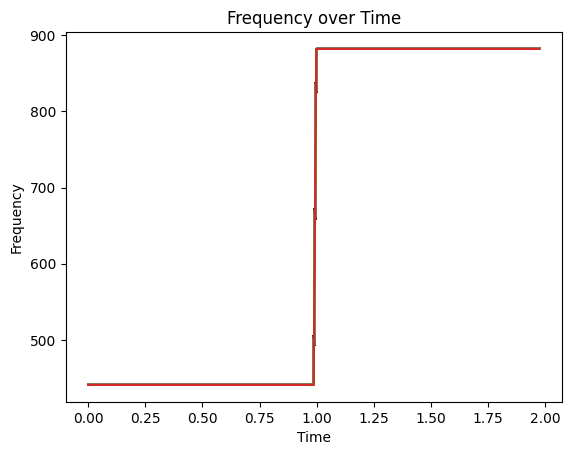

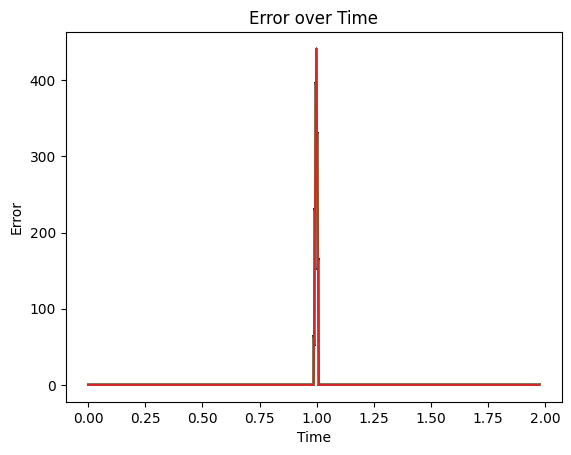

In [85]:
plot_test(sx, 1024, 512, 44100)

In [86]:
convert_freq2midi(f0)

array([[69.03930158, 69.03930158, 69.03930158, ..., 69.03930158,
        69.03930158, 69.03930158],
       [69.03930158, 69.03930158, 69.03930158, ..., 69.03930158,
        69.03930158, 69.03930158],
       [69.03930158, 69.03930158, 69.03930158, ..., 69.03930158,
        69.03930158, 69.03930158],
       ...,
       [81.03930158, 81.03930158, 81.03930158, ..., 81.03930158,
        81.03930158, 81.03930158],
       [81.03930158, 81.03930158, 81.03930158, ..., 81.03930158,
        81.03930158, 81.03930158],
       [81.03930158, 81.03930158, 81.03930158, ..., 81.03930158,
        81.03930158, 81.03930158]])

In [87]:
def run_evaluation(complete_path_to_data_folder):
   all_errors = []
   #search given directory for wav files
   for filename in glob.glob(os.path.join(complete_path_to_data_folder, '*.wav')):
      #import wav file as audio_data
      fs, audio_data = scipy.io.wavfile.read(filename)
      estimated_pitch, _ = track_pitch_acf(audio_data, 1024,512, fs)
      groundtruth_file = filename.replace('.wav', '.f0.Corrected.txt')
      groundtruth_data = np.loadtxt(groundtruth_file)


      new_estimated_pitch = np.zeros((len(groundtruth_data)))
      new_groundtruth_data = np.zeros((len(groundtruth_data)))
      
      for i in range(len(estimated_pitch)):
         new_estimated_pitch[i] = estimated_pitch[i][0]

      for i in range(len(groundtruth_data)):
         new_groundtruth_data[i] = groundtruth_data[i][0]


      error = eval_pitchtrack(new_estimated_pitch, new_groundtruth_data)
      all_errors.append(error)
   
   #overall_error = np.mean(all_errors)
   for i in range(len(all_errors)):
      print(f"Overall Error in Cents RMS for file {i}: {all_errors[i]}")

   return all_errors


err = run_evaluation("trainData")

/var/folders/r7/14rq71vn0wgf5_0dd1_6_h380000gn/T/ipykernel_83594/829524153.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio_data = scipy.io.wavfile.read(filename)


Overall Error in Cents RMS for file 0: 7525.052494573801
Overall Error in Cents RMS for file 1: 9166.707292365929
Overall Error in Cents RMS for file 2: 8480.197700028739
